# Notebook tutorial to get you started with simulated Lagrangian particle trajectories in a HYCOM 1/25 run
by Shane Elipot (selipot@miami.edu)

In this notebook tutorial you will learn how to access the Lagrangian data of the dataset **Eulerian and Lagrangian near-surface velocity and sea surface height from one year of the global HYbrid Coordinate Ocean Model (HYCOM)** hosted on the AWS S3 bucket `hycom-global-drifters`. You will also learn how to conduct some visualization of the velocity and sea surface height (SSH) data. 

The data in the bucket are archived as zarr *files*, *store*, or again *archive*. In the rest of this notebook we will use the name *store*.

To run this notebook you will need a python environment with the common libraries *numpy*, *xarray*, and *matplotlib*. The last part of the tutorial requires some more specialized functions from the *spectrum* and *clouddrift* packages.  

### Library import

In [1]:
# computational imports
import numpy as np
import xarray as xr

# plotting imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cmocean

# AWS import
import s3fs

# specialized imports
import spectrum 
from clouddrift.ragged import rowsize_to_index, subset, regular_to_ragged
from clouddrift.plotting import plot_ragged

### AWS S3 bucket file access set up:

Here we access the bucket `hycom-global-drifters` by using the *s3fs* package that allows to mount a remote directory. Because the bucket is not public yet we need to use access keys.

In [2]:
#AWS set up
bucket_name = 'hycom-global-drifters'

s3 = s3fs.S3FileSystem(anon=True)

In this tutorial we are interested in the Lagrangian dataset which is contained under the `lagrangian` "directory" of the bucket. We list the content of this directory which consists of zarr stores. There are 11 stores for the particles advected at the surface and 11 stores for the particles advected at 15 m depth.

In [3]:
# Get the objects in the directory
directory = bucket_name + '/lagrangian'
objects = s3.ls(directory)
# Print the objects
for obj in objects:
    print(obj)

hycom-global-drifters/lagrangian/
hycom-global-drifters/lagrangian/global_hycom_0m_step_1.zarr
hycom-global-drifters/lagrangian/global_hycom_0m_step_10.zarr
hycom-global-drifters/lagrangian/global_hycom_0m_step_11.zarr
hycom-global-drifters/lagrangian/global_hycom_0m_step_2.zarr
hycom-global-drifters/lagrangian/global_hycom_0m_step_3.zarr
hycom-global-drifters/lagrangian/global_hycom_0m_step_4.zarr
hycom-global-drifters/lagrangian/global_hycom_0m_step_5.zarr
hycom-global-drifters/lagrangian/global_hycom_0m_step_6.zarr
hycom-global-drifters/lagrangian/global_hycom_0m_step_7.zarr
hycom-global-drifters/lagrangian/global_hycom_0m_step_8.zarr
hycom-global-drifters/lagrangian/global_hycom_0m_step_9.zarr
hycom-global-drifters/lagrangian/global_hycom_15m_step_1.zarr
hycom-global-drifters/lagrangian/global_hycom_15m_step_10.zarr
hycom-global-drifters/lagrangian/global_hycom_15m_step_11.zarr
hycom-global-drifters/lagrangian/global_hycom_15m_step_2.zarr
hycom-global-drifters/lagrangian/global_hyc

## Getting some data:

Next we are going to specifically work with one of the stores, here the 11-th one at 15-m depth (Feel free to chose another depth, or another step between 1 and 11):

In [4]:
# choose step and depth
step = 11
depth = 15
# Define the path and get the size of the selected data:
zarr_store_path = bucket_name+'/lagrangian/global_hycom_'+str(depth)+'m_step_'+str(step)+'.zarr'
print(f"The velocity store is {np.round(s3.du(zarr_store_path, total=True)/1024**3,0)} GB.")
# Create Zarr store mapped objects
store = s3fs.S3Map(root=zarr_store_path, s3=s3)

The velocity store is 15.0 GB.


To work with the data we are choosing here to use the functionalities of the [xarray](https://docs.xarray.dev/en/stable/) package that allows us to easily open a zarr store:

In [5]:
# Open the zarr dataset using xarray
ds = xr.open_zarr(s3.get_mapper(zarr_store_path), consolidated=True)
ds

<xarray.Dataset>
Dimensions:     (traj: 587225, obs: 1440)
Coordinates:
    id          (traj) int64 dask.array<chunksize=(587225,), meta=np.ndarray>
  * obs         (obs) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
Dimensions without coordinates: traj
Data variables:
    depth       (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    grounding   (traj, obs) bool dask.array<chunksize=(93206, 1440), meta=np.ndarray>
    lat         (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    lon         (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    ssh         (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    steric_ssh  (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(9176, 45), meta=np.ndarray>
    ve          (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    vn          (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
Attributes:
    feature_type:      trajectory
    parcels_mesh:      spherical
    parcels_versions:  2.4.1.dev9

## Working with the data:

This dataset is relatively large so we are going to subset it to be able to do some work locally without downloading the entire set. The trajectories were generated by advecting the particles forward and backward from the middle time point `(time=720)` starting from a regular 1/4 degree grid. These starting locations are ordered inn increasing order of longitude which we can seen by plotting all longitudes at the middle time (this step requires to actually download some of the data locally on your machine, be patient):

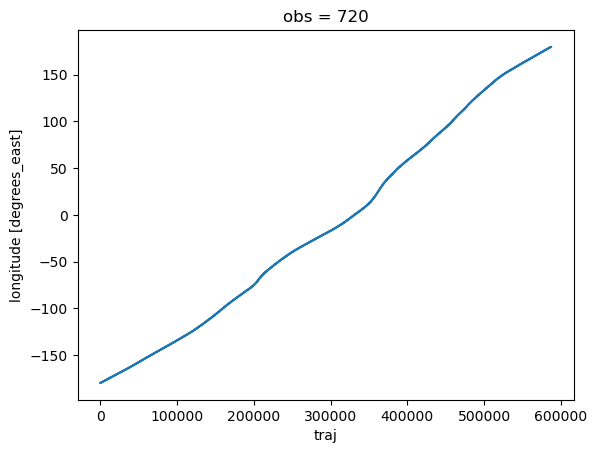

In [6]:
# plot the longitude of particles at middle time
ds["lon"].isel(obs=720).plot()

You can see that there are 593, 292 (or 587,225) particles in the dataset. We are going to select here only the particles that cross the Equator at their mid-point in time. We first create a mask and then apply that mask to the dataset to create a new dataset which we download locally.

Note: Notice that we need to explictly apply the `.compute()` method to use the mask because the data are [dask arrays](https://docs.dask.org/en/latest/array.html) under the hood.

In [7]:
# let's select trajectories that traverse the equator at mid-time 
# here we need to use the .drop_vars() method to remove the obs dimension to 
# make sure the mask can be applied along the trajectory dimension (traj) in the next step
mask = (ds["lat"].isel(obs=slice(None))[:,720]==0).drop_vars("obs").compute()

In [8]:
# Now use the mask to filter and obtain a new Dataset; this may take some time, be patient
ds_eq = ds.isel(traj=mask).load()
ds_eq

<xarray.Dataset>
Dimensions:     (traj: 1118, obs: 1440)
Coordinates:
    id          (traj) int64 280 861 1442 2023 ... 834596 835177 835758 836339
  * obs         (obs) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
Dimensions without coordinates: traj
Data variables:
    depth       (traj, obs) float32 5.025e+03 5.029e+03 ... 5.431e+03 5.403e+03
    grounding   (traj, obs) bool False False False False ... False False False
    lat         (traj, obs) float32 -2.805 -2.798 -2.79 ... 1.539 1.55 1.561
    lon         (traj, obs) float32 175.4 175.4 175.4 ... -179.9 -179.9 -179.9
    ssh         (traj, obs) float32 -0.2971 -0.1333 0.1896 ... 0.508 0.2248
    steric_ssh  (traj, obs) float32 0.5715 0.5807 0.5974 ... 0.4985 0.5046
    time        (traj, obs) datetime64[ns] 2014-10-28T01:00:00 ... 2014-12-27
    ve          (traj, obs) float32 0.173 0.173 0.173 ... -0.247 -0.2293 -0.2293
    vn          (traj, obs) float32 0.2192 0.2417 0.2643 ... 0.3223 0.3223
Attributes:
    feature_type:      trajectory
    parcels_mesh:      spherical
    parcels_versions:  2.4.1.dev9

We now visualize the selected trajectories by creating a simple geographical map using the [cartopy](https://scitools.org.uk/cartopy/docs/latest/index.html) package:

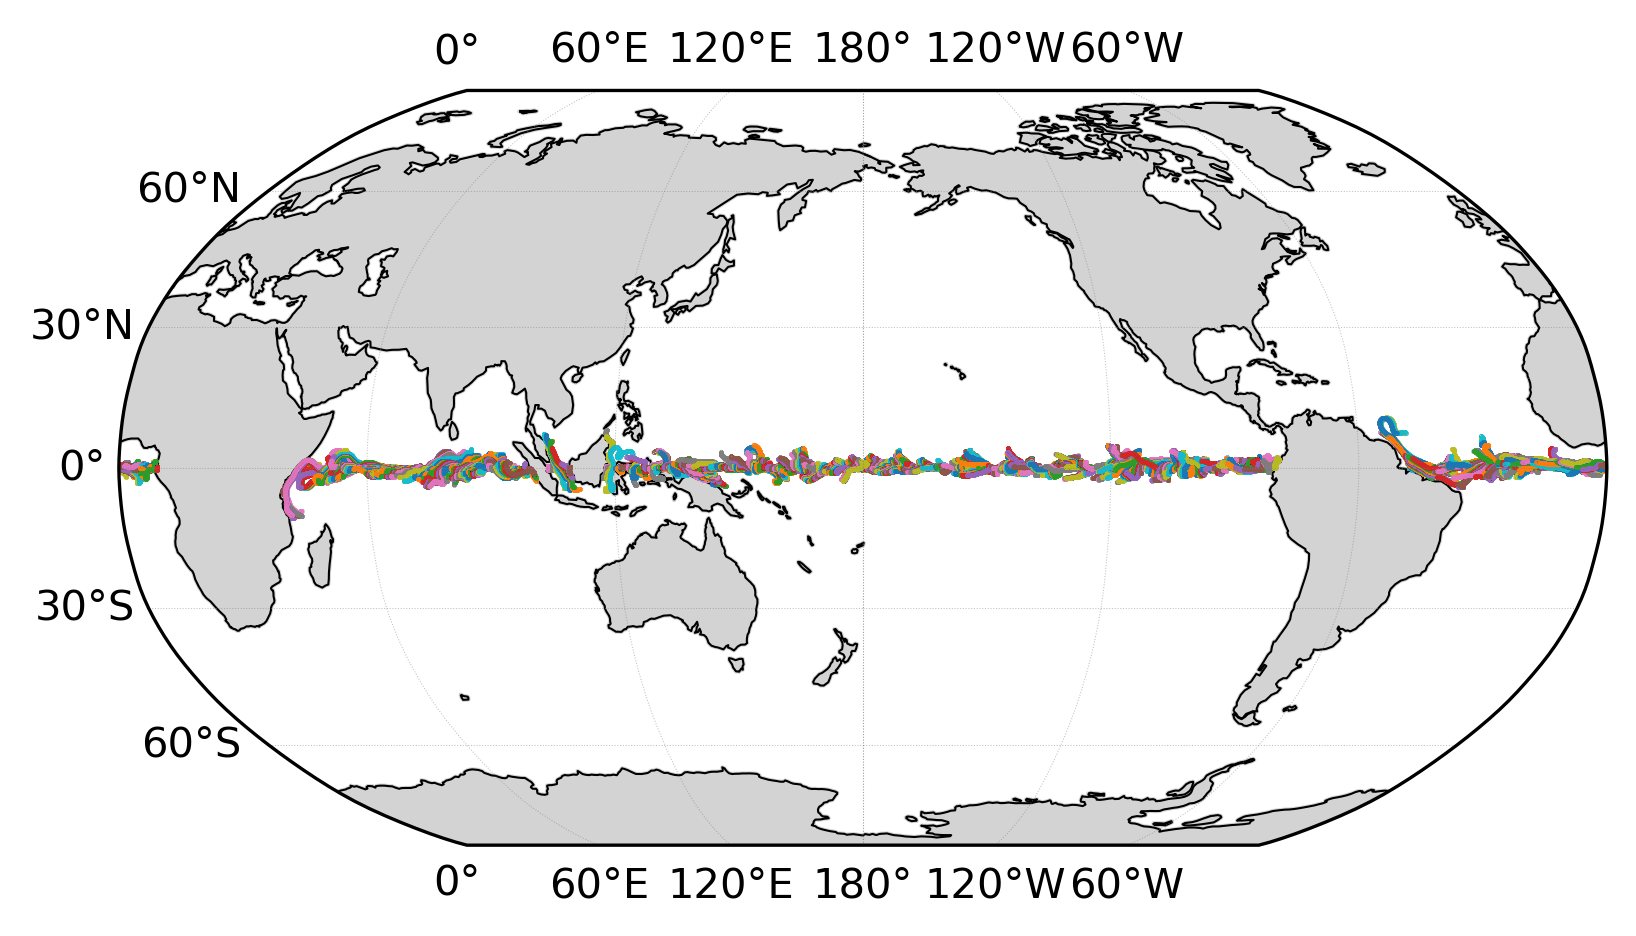

In [17]:
# Create a new figure
fig = plt.figure(dpi=300)

# Create a map projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))
ax.set_global()  # Set the extent to the global extent of the projection
# plot the trajectory
ax.plot(ds_eq["lon"][::2,:].transpose(), ds_eq["lat"][::2,:].transpose(), transform=ccrs.PlateCarree(), 
    linewidth=0,marker='.',markersize=.05)

# Add coastlines
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgrey')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.25, color='gray', alpha=0.5, linestyle=':')

## Working further with the data using the *clouddrift* package

The advection scheme used to create the particle trajectories was such that the particles could become *grounded* (or *beached*) if they approached the coast in an infinitesimal manner. An estimate of such grounding is provided in the dataset thanks to the **grounding** variable which is **True** if a particle is estimated grounded at any given time. Please see the [data description](https://github.com/selipot/hycom-global-drifters/blob/main/data-bucket-description.md) and some sample code in the repository [hycom-global-drifters](https://github.com/selipot/hycom-global-drifters).

We would like to get rid of the data points when the particle is grounded. For this, first we copy our equatorial dataset (**ds_eq**) into a new dataset **ds_ng** to which we apply the grounding mask variable per variable in order to replace all grounded values by **NaN** or **NaT**. Second, we transform the dataset from being composed of *regular* two-dimensional arrays to a dataset composed of *ragged* arrays. This is achieved thanks to the function [`regular_to_ragged`](https://clouddrift.org/_autosummary/clouddrift.ragged.regular_to_ragged.html#clouddrift.ragged.regular_to_ragged) of the `clouddrift.ragged` module.

You can learn more about the ragged array representation for Lagrangian data in the [documentation](https://clouddrift.org) of the clouddrift python package.

In [10]:
# create a new dataset ds_ng where we mask all grounded data
ds_ng = ds_eq.drop_vars("grounding")
# replace the grounding times with NaNs
for var in ds_ng.data_vars:
    if ds_ng[var].dtype == 'datetime64[ns]':
        ds_ng[var] = ds_ng[var].where(~ds_eq["grounding"], other=np.datetime64('NaT'))
    else:
        ds_ng[var] = ds_ng[var].where(~ds_eq["grounding"], other=np.nan)

In [11]:
# create a new dataset ds_rag which contains ragged array data
n_traj = ds_ng.sizes["traj"]
n_obs = ds_ng["lat"].count().values

# initialize the Dataset
ds_rag = xr.Dataset(
    coords={
        'id': ('traj', ds_ng["id"].data),
        'obs': ('obs', range(n_obs))
    }
)
for var in ds_ng.data_vars:
    dum, rowsize = regular_to_ragged(ds_ng[var].to_numpy(), fill_value=np.nan)
    ds_rag[var] = xr.DataArray(dum, dims=("obs"), name=var)

# finally assign the rowsize variable to the dataset
ds_rag["rowsize"] = xr.DataArray(rowsize, dims=("traj"), name="rowsize")

ds_rag 

<xarray.Dataset>
Dimensions:     (traj: 1118, obs: 1592862)
Coordinates:
    id          (traj) int64 280 861 1442 2023 ... 834596 835177 835758 836339
  * obs         (obs) int64 0 1 2 3 4 ... 1592858 1592859 1592860 1592861
Dimensions without coordinates: traj
Data variables:
    depth       (obs) float32 5.025e+03 5.029e+03 ... 5.431e+03 5.403e+03
    lat         (obs) float32 -2.805 -2.798 -2.79 -2.782 ... 1.539 1.55 1.561
    lon         (obs) float32 175.4 175.4 175.4 175.4 ... -179.9 -179.9 -179.9
    ssh         (obs) float32 -0.2971 -0.1333 0.1896 ... 0.7726 0.508 0.2248
    steric_ssh  (obs) float32 0.5715 0.5807 0.5974 ... 0.4928 0.4985 0.5046
    time        (obs) datetime64[ns] 2014-10-28T01:00:00 ... 2014-12-27
    ve          (obs) float32 0.173 0.173 0.173 ... -0.247 -0.2293 -0.2293
    vn          (obs) float32 0.2192 0.2417 0.2643 ... 0.3351 0.3223 0.3223
    rowsize     (traj) int64 1440 1440 1440 1440 1440 ... 1440 1440 1440 1440

Now that we have removed the grounding times for all particles, the particle trajectories are not all of length 1440 or 60 days. Let's plot the length of each trajectory:

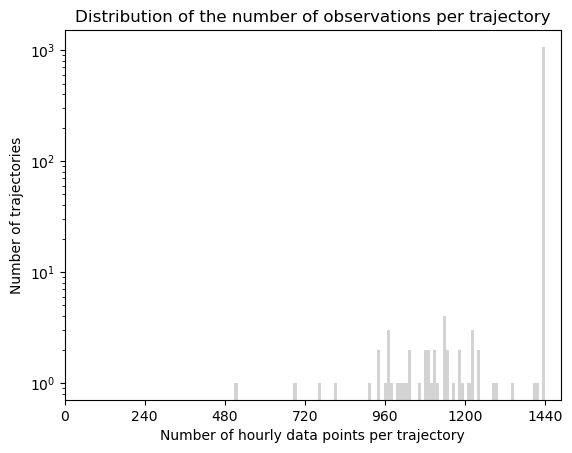

In [12]:
# plot a simple curve of the rowsize variable to see the distribution of the 
# number of observations per trajectory
fig, ax = plt.subplots()
ax.hist(ds_rag["rowsize"], bins=100, color='lightgrey')
ax.set_yscale('log')
ax.set_xticks(range(0, 1440+24, 24*10))
ax.set_xlabel('Number of hourly data points per trajectory')
ax.set_ylabel('Number of trajectories')
ax.set_title('Distribution of the number of observations per trajectory');

Now, let's say that we want to keep particle trajectories that are least of 40-day length, or 960 data points. We can do this easily by using the [`subset`](https://clouddrift.org/_autosummary/clouddrift.ragged.subset.html#clouddrift.ragged.subset) function of the `clouddrift.ragged` module. 

In [13]:
threshold = 40*24
ds_rag_40 = subset(ds_rag, {"rowsize": (threshold,np.Inf)})
ds_rag_40

<xarray.Dataset>
Dimensions:     (traj: 1111, obs: 1587290)
Coordinates:
    id          (traj) int64 280 861 1442 2023 ... 834596 835177 835758 836339
  * obs         (obs) int64 0 1 2 3 4 ... 1592858 1592859 1592860 1592861
Dimensions without coordinates: traj
Data variables:
    depth       (obs) float32 5.025e+03 5.029e+03 ... 5.431e+03 5.403e+03
    lat         (obs) float32 -2.805 -2.798 -2.79 -2.782 ... 1.539 1.55 1.561
    lon         (obs) float32 175.4 175.4 175.4 175.4 ... -179.9 -179.9 -179.9
    ssh         (obs) float32 -0.2971 -0.1333 0.1896 ... 0.7726 0.508 0.2248
    steric_ssh  (obs) float32 0.5715 0.5807 0.5974 ... 0.4928 0.4985 0.5046
    time        (obs) datetime64[ns] 2014-10-28T01:00:00 ... 2014-12-27
    ve          (obs) float32 0.173 0.173 0.173 ... -0.247 -0.2293 -0.2293
    vn          (obs) float32 0.2192 0.2417 0.2643 ... 0.3351 0.3223 0.3223
    rowsize     (traj) int64 1440 1440 1440 1440 1440 ... 1440 1440 1440 1440

Finally, let's plot all the remaining trajectories, coloring them by their speed. This is easily achieved thanks to the [`plot_raggedd`](https://clouddrift.org/_autosummary/clouddrift.plotting.plot_ragged.html) function of the `clouddrift.plotting` module. 

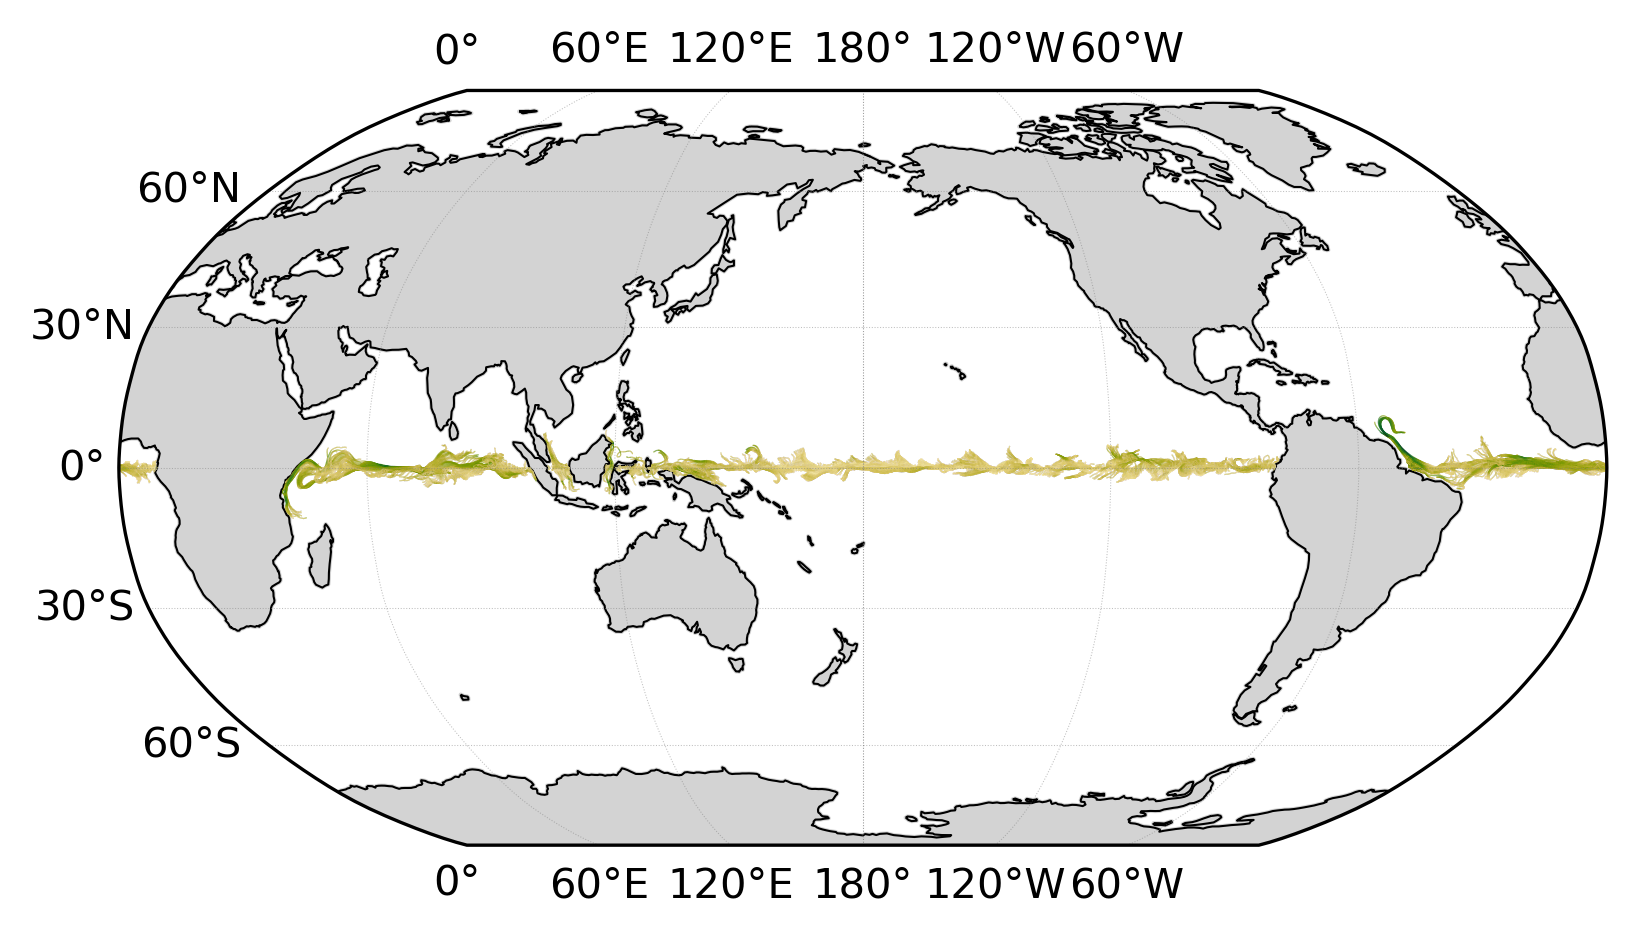

In [14]:
# Create a new figure
fig = plt.figure(dpi=300)

# Create a map projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))
# plot the trajectory colored by spin
lc = plot_ragged(ax,ds_rag_40["lon"], ds_rag_40["lat"], ds_rag_40["rowsize"], colors = (ds_rag_40["ve"]**2+ds_rag_40["vn"]**2)**0.5, 
    cmap=cmocean.cm.speed, transform=ccrs.PlateCarree(), linewidth=0.25)
ax.set_global()  # Set the extent to the global extent of the projection

# Add coastlines
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgrey')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.25, color='gray', alpha=0.5, linestyle=':')